<a href="https://colab.research.google.com/github/atolia/colabs/blob/main/Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
try:
  import yfinance as yf
  import mibian
except Exception:
  !pip install yfinance > /dev/null 2>&1
  !pip install mibian >/dev/null
  import yfinance as yf
  import mibian
import pandas as pd
from google.colab import data_table
from datetime import datetime
import math
import numpy as np
# from types import SimpleNamespace
from IPython.display import Markdown, display, Javascript

def printmd(string):
    display(Markdown(string))

date_format = "%Y-%m-%d"
#@title Stock common info { vertical-output: true, display-mode: "form" }
symbol = "AAPL" #@param {type:"string"}
ticker = yf.Ticker(symbol) 
distanceStrike =   6#@param {type:"integer"}
distanceDate =   6#@param {type:"integer"}
commissionUSD = 1.5 #@param {type:"number"}
hist1y = ticker.history(period='1y')
# ' '.join([prop for prop in ticker.info ])

def showPUTs(ticker, deltaLimit=-0.3 ):
  final = [];
  tdPrc = ticker.info['regularMarketPrice']
  ytdPrc = ticker.info['regularMarketPreviousClose']
  diff= (tdPrc-ytdPrc)/ytdPrc*100
  interest_rate = 0
  colsArr = [ 'days', 'Strike', 'today Change%', 'Profit $', '$/day', 'Profit %', 'Profit 1Y %', 'IV', 'OI', 'Delta', 'DualDelta', 'Gamma']
  for j in range(0, min(distanceDate, len(ticker.options)-1)):
    out = [];
    opdtstr = ticker.options[j]
    puts = ticker.option_chain(opdtstr).puts
    inMndx1 = puts.loc[puts['inTheMoney'] == True].index
    if len(inMndx1)>0:
      inMndx = inMndx1[0] 
    if inMndx < 1:
      continue
    opdt = datetime.strptime(opdtstr, date_format)
    # print( f'\n   ========== Expiration date: {opdtstr} ==================', end='')
    for i in range(max(0, (inMndx-distanceStrike-1)), inMndx):
      dysLeft = (opdt-datetime.now()).days+1
      if dysLeft < 2 or i == len(puts)-1:
        continue
      if puts.iloc[i].inTheMoney:
        continue
      prc = puts.iloc[i].bid or puts.iloc[i].lastPrice or puts.iloc[i].ask
      earnPerDay = round(prc/dysLeft*100, 2)
      OI = round(puts.iloc[i].openInterest, 2)
      IV = round(puts.iloc[i].impliedVolatility*100, 2)
      # p = mibian.BS(  [tdPrc, puts.iloc[i].strike, interest_rate, dysLeft], putPrice=prc);
      p = mibian.BS(  [tdPrc, puts.iloc[i].strike, interest_rate, dysLeft], volatility=IV);

      profitUSD = prc*100 - commissionUSD
      profit = profitUSD/tdPrc
      change = 0 if math.isnan(puts.iloc[i].percentChange) else round(puts.iloc[i].percentChange)
      toAdd = [ dysLeft, puts.iloc[i].strike, change, profitUSD, earnPerDay, profit, profit/dysLeft*365, IV, OI, p.putDelta, p.putDelta2, p.gamma]
      out.append(toAdd)
      final.append(toAdd)
    # display(pd.DataFrame(out, columns = colsArr ).round(2))

  # openInterest	impliedVolatility
  df = pd.DataFrame(final, columns = colsArr).sort_values(by=colsArr[6], ascending=False)
  df = df[df.Delta > deltaLimit]

  print()
  printmd(f" - Prev.Day price {round(ytdPrc,2)}, Current price **{round(tdPrc,2)}**, diff: {round(diff,2)}%.")
  printmd(f"- Final list OutOfMoney PUTS for nearest {distanceStrike} Strikes and {distanceDate} Dates. Sorted by **1 year profit**. With Delta lower than **30**")
  
  return df
  # print('\n==== Total: =====')

  # .style.hide_index().format({'Strike':'{:.5}', 'Credit$':'{:.5}','$/day':'{:.5}','Profit%':'{:.3}', '1Y-yield%':'{:.4}', 'IV':'{:.4}'})


In [ ]:
df = showPUTs(yf.Ticker(symbol)) 
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200) # , min_width="500"

 - Prev.Day price 172.14, Current price **170.33**, diff: -1.05%.

- Final list OutOfMoney PUTS for nearest 6 Strikes and 6 Dates. Sorted by **1 year profit**. With Delta lower than **30**

,days,Strike,today Change%,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
34,35,170.0,0,548.5,15.71,3.22,33.58,0.20,1319.0,-0.00,0.00,0.03
12,14,167.5,3,197.5,14.21,1.16,30.23,1.56,3142.0,-0.00,0.00,0.00
4,6,165.0,16,84.5,14.33,0.50,30.18,29.40,39837.0,-0.19,0.20,0.04
33,35,165.0,0,350.5,10.06,2.06,21.46,3.13,868.0,-0.00,0.00,0.00
11,14,165.0,0,138.5,10.00,0.81,21.20,25.38,20223.0,-0.25,0.27,0.04
3,6,162.5,15,50.5,8.67,0.30,18.04,31.45,6662.0,-0.12,0.13,0.03
25,28,160.0,0,223.5,8.04,1.31,17.10,33.00,5977.0,-0.23,0.26,0.02
18,21,160.0,2,164.5,7.90,0.97,16.79,6.25,10612.0,-0.00,0.00,0.00
32,35,160.0,16,270.5,7.77,1.59,16.56,32.64,1839.0,-0.25,0.28,0.02
10,14,162.5,3,100.5,7.29,0.59,15.38,6.25,1298.0,-0.00,0.00,0.00


Dual Delta is like Delta but caclulated from Strike instead of StockPrice [More about Dual Delta ](http://jtoll.com/post/duel-of-the-deltas/)

**QQQ:**

In [ ]:
df = showPUTs(yf.Ticker('QQQ'), -0.4) 
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200)

 - Prev.Day price 354.1, Current price **348.97**, diff: -1.45%.

- Final list OutOfMoney PUTS for nearest 6 Strikes and 6 Dates. Sorted by **1 year profit**. With Delta lower than **30**

,days,Strike,today Change%,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
10,5,346.0,48,286.5,57.60,0.82,59.93,23.93,1079.0,-0.37,0.39,0.04
17,6,346.0,26,337.5,56.50,0.97,58.83,25.12,5209.0,-0.39,0.40,0.03
9,5,345.0,49,266.5,53.60,0.76,55.75,25.00,955.0,-0.34,0.35,0.04
16,6,345.0,41,310.5,52.00,0.89,54.13,25.53,87307.0,-0.36,0.37,0.03
3,3,346.0,64,154.5,52.00,0.44,53.87,19.65,2757.0,-0.31,0.32,0.06
15,6,344.0,42,279.5,46.83,0.80,48.72,25.88,8630.0,-0.33,0.34,0.03
8,5,344.0,46,231.5,46.60,0.66,48.43,24.93,800.0,-0.31,0.32,0.03
14,6,343.0,39,253.5,42.50,0.73,44.19,26.21,5268.0,-0.30,0.31,0.03
2,3,345.0,77,125.5,42.33,0.36,43.75,19.63,4181.0,-0.26,0.26,0.05
7,5,343.0,42,204.5,41.20,0.59,42.78,25.35,216.0,-0.28,0.29,0.03


**SPY:**

In [ ]:
df = showPUTs(yf.Ticker('SPY'), -0.4) 
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200) 

 - Prev.Day price 448.77, Current price **446.71**, diff: -0.46%.

- Final list OutOfMoney PUTS for nearest 6 Strikes and 6 Dates. Sorted by **1 year profit**. With Delta lower than **30**

,days,Strike,today Change%,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
5,3,445.0,38,189.5,63.67,0.42,51.61,14.69,7468.0,-0.38,0.39,0.06
11,5,444.0,24,272.5,54.80,0.61,44.53,17.59,2559.0,-0.38,0.39,0.04
18,6,444.0,24,314.5,52.67,0.70,42.83,18.09,15375.0,-0.39,0.40,0.04
4,3,444.0,42,154.5,52.00,0.35,42.08,14.81,13115.0,-0.32,0.33,0.06
17,6,443.0,23,281.5,47.17,0.63,38.33,18.34,11765.0,-0.36,0.37,0.04
10,5,443.0,23,234.5,47.20,0.52,38.32,17.61,1847.0,-0.34,0.35,0.04
16,6,442.0,18,255.5,42.83,0.57,34.79,18.76,12098.0,-0.33,0.33,0.03
9,5,442.0,16,205.5,41.40,0.46,33.58,17.85,1692.0,-0.30,0.31,0.04
3,3,443.0,32,122.5,41.33,0.27,33.36,14.80,3656.0,-0.26,0.27,0.05
15,6,441.0,18,229.5,38.50,0.51,31.25,19.07,11462.0,-0.30,0.30,0.03


Overal info:

In [147]:
#@title INFO { vertical-output: true }
if  ticker.info.get('longName'):
  printmd('- **Name:** ' + ticker.info['longName'] )

printmd('- **Expiration dates:** '+' '.join([dt for dt in ticker.options ]) )
printmd('- **Country:** ' + getattr(ticker,'country', 'Unknown') +' **Sector:** ' + getattr(ticker,'sector', 'Unknown') + ' **Industry:** ' + getattr(ticker,'industry', 'Unknown') + ' **MarketCap:** ' + str(round( getattr(ticker,'marketCap', 0) /1000/1000/1000,2)) + "B" )

if  ticker.info.get('longBusinessSummary'):
  printmd('- **Summary:** ' + ticker.info['longBusinessSummary'] )
if  ticker.info.get('dividendYield'):
  printmd('- **dividendYield:** ' + str(round((ticker.info['dividendYield'] or 0)*100, 2)) + '%' + 
          ' **trailingAnnualDividendYield:** ' + str(round((ticker.info['trailingAnnualDividendYield'] or 0)*100, 2)) + '%' +
          ' **Frwd.dividend/yr:** ' + str(round((ticker.info['dividendRate'] or 0), 2)) + '$' )
  printmd('- **exDividendDate:** ' + datetime.strftime(datetime.fromtimestamp(ticker.info['exDividendDate'] or 0), date_format+' %Z'))
else:
  print('No dividends')  
printmd('- **totalRevenue:** ' + str(round(getattr(ticker,'totalRevenue', 0)/1e9, 2)) + 'B' + ' **revenueGrowth:** ' + str(round(getattr(ticker,'revenueGrowth', 0)*100, 2)) + '%' + ' **grossMargins:** ' + str(round(getattr(ticker,'grossMargins',0)*100, 2)) + '%' + ' **ebitdaMargins:** ' + str(round(getattr(ticker,'ebitdaMargins',0)*100, 2)) + '%')
if  ticker.info.get('trailingEps'):
  printmd('- **trailingEps:** ' + str(round(ticker.info['trailingEps'], 2)) + '\$' + ' **forwardEps:** ' + str(round(ticker.info['forwardEps'], 4)) + '$')
else:
  print('No EPS')  
printmd('- **StockPrice:** ``$' + str(round(ticker.info['regularMarketPrice'], 2)) + '``' +
        ' **1yr min:** ``$' + str(round((hist1y['Close'].min()), 2)) + '``' +
        ' **max:** ``$' + str(round((hist1y['Close'].max()), 2)) + '``' +
        ' **mean:** ``$' + str(round((hist1y['Close'].mean()), 2)) + '``' +
        ' **std:** ``$' + str(round((hist1y['Close'].std()), 2)) + '``' +
        ' **variance:** ' + str(round(hist1y['Close'].std()/hist1y['Close'].mean()*100, 2) ) + '%' 
        )
if len(ticker.get_splits()):
  printmd('**Splits:** ')
  ticker.get_splits()


- **Name:** Apple Inc.

- **Expiration dates:** 2022-04-14 2022-04-22 2022-04-29 2022-05-06 2022-05-13 2022-05-20 2022-06-17 2022-07-15 2022-08-19 2022-09-16 2022-10-21 2022-11-18 2023-01-20 2023-03-17 2023-06-16 2023-09-15 2024-01-19 2024-06-21

- **Country:** Unknown **Sector:** Unknown **Industry:** Unknown **MarketCap:** 0.0B

- **Summary:** Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. In addition, the company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; AirPods Max, an over-ear wireless headphone; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, and iPod touch. Further, it provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. Additionally, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand radio stations; Apple News+, a subscription news and magazine service; Apple TV+, which offers exclusive original content; Apple Card, a co-branded credit card; and Apple Pay, a cashless payment service, as well as licenses its intellectual property. The company serves consumers, and small and mid-sized businesses; and the education, enterprise, and government markets. It distributes third-party applications for its products through the App Store. The company also sells its products through its retail and online stores, and direct sales force; and third-party cellular network carriers, wholesalers, retailers, and resellers. Apple Inc. was incorporated in 1977 and is headquartered in Cupertino, California.

- **dividendYield:** 0.52% **trailingAnnualDividendYield:** 0.5% **Frwd.dividend/yr:** 0.88$

- **exDividendDate:** 2022-02-04 

- **totalRevenue:** 0.0B **revenueGrowth:** 0% **grossMargins:** 0% **ebitdaMargins:** 0%

- **trailingEps:** 6.01\$ **forwardEps:** 6.57$

- **StockPrice:** ``$170.09`` **1yr min:** ``$122.25`` **max:** ``$181.78`` **mean:** ``$151.35`` **std:** ``$16.39`` **variance:** 10.83%

**Splits:** 

In [ ]:
# CALLS:
# symbol = "PLTR" 
# # symbol = "VIPS" 
# ticker = yf.Ticker(symbol) 
# distanceStrike =   5 
# distanceDate =   6 


final = [];
tdPrc = ticker.info['regularMarketPrice']
ytdPrc = ticker.info['regularMarketPreviousClose']
diff= (tdPrc-ytdPrc)/ytdPrc*100
interest_rate = 0
colsArr = [ 'days', 'Strike', 'Change%', 'ITM', 'Profit $', '$/day', 'Profit %', 'Profit 1Y %', 'IV', 'OI', 'Delta', 'DualDelta', 'Gamma']
for j in range(0, min(distanceDate, len(ticker.options)-1)):
  out = [];
  opdtstr = ticker.options[j]
  calls = ticker.option_chain(opdtstr).calls
  inMndx1 = calls.loc[calls['inTheMoney'] == True].index
  if len(inMndx1)>0:
     inMndx = inMndx1[-1] 
  if inMndx < 1:
    continue
  opdt = datetime.strptime(opdtstr, date_format)
  print( f'\n   ========== Expiration date: {opdtstr} ==================', end='')
  for i in range(inMndx, min(len(calls)-1, (inMndx+distanceStrike-1))):
    dysLeft = (opdt-datetime.now()).days+1
    # if dysLeft < 2:
    if dysLeft < 2 or calls.iloc[i].inTheMoney:
      continue
    prc = calls.iloc[i].bid or calls.iloc[i].lastPrice or calls.iloc[i].ask
    earnPerDay = round(prc/dysLeft*100, 2)
    OI = round(calls.iloc[i].openInterest, 2)
    IV = round(calls.iloc[i].impliedVolatility*100, 2)
    # p = mibian.BS(  [tdPrc, calls.iloc[i].strike, interest_rate, dysLeft], putPrice=prc);
    bs = mibian.BS(  [tdPrc, calls.iloc[i].strike, interest_rate, dysLeft], volatility=IV);

    profitUSD = prc*100 - commissionUSD
    profit = profitUSD/tdPrc
    change = 0 if math.isnan(calls.iloc[i].percentChange) else round(calls.iloc[i].percentChange)
    toAdd = [ dysLeft, calls.iloc[i].strike, change, calls.iloc[i].inTheMoney, profitUSD, earnPerDay, profit, profit/dysLeft*365, IV, OI, bs.callDelta, bs.callDelta2, bs.gamma]
    out.append(toAdd)
    final.append(toAdd)
  display(pd.DataFrame(out, columns = colsArr ).round(2))

# openInterest	impliedVolatility
df = pd.DataFrame(final, columns = colsArr)
print()
printmd(f" - Prev.Day price {round(ytdPrc,2)}, Current price **{round(tdPrc,2)}**, diff: {round(diff,2)}%."+
        f" Final list ITM and OutOfMoney calls for nearest {distanceStrike} Strikes and {distanceDate} Dates")

# print('\n==== Total: =====')
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200  ) # , min_width="500"



   ========== Expiration date: 2022-04-08 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma



   ========== Expiration date: 2022-04-14 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,7,172.5,-10,False,216.5,31.14,1.26,65.72,25.33,18574.0,0.46,-0.44,0.07
1,7,175.0,-19,False,113.5,16.43,0.66,34.46,24.12,43724.0,0.29,-0.28,0.06
2,7,177.5,-20,False,54.5,8.00,0.32,16.54,23.83,22630.0,0.16,-0.16,0.04
3,7,180.0,-23,False,24.5,3.71,0.14,7.44,24.07,51074.0,0.08,-0.08,0.03
4,7,182.5,-22,False,11.5,1.86,0.07,3.49,25.20,15141.0,0.04,-0.04,0.02
5,7,185.0,-20,False,5.5,1.00,0.03,1.67,26.66,39701.0,0.02,-0.02,0.01
6,7,187.5,0,False,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
7,7,190.0,0,False,1.5,0.43,0.01,0.46,31.06,21586.0,0.01,-0.01,0.00



   ========== Expiration date: 2022-04-22 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,15,172.5,0,False,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
1,15,175.0,-6,False,194.5,13.07,1.13,27.55,23.50,20894.0,0.36,-0.34,0.05
2,15,177.5,0,False,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
3,15,180.0,-12,False,63.5,4.33,0.37,9.00,22.32,19224.0,0.16,-0.15,0.03
4,15,182.5,0,False,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
5,15,185.0,-24,False,19.5,1.40,0.11,2.76,23.00,13837.0,0.06,-0.05,0.01
6,15,187.5,0,False,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
7,15,190.0,-9,False,7.5,0.60,0.04,1.06,25.29,9069.0,0.03,-0.02,0.01



   ========== Expiration date: 2022-04-29 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,22,175.0,-6,False,343.5,15.68,2.00,33.18,28.85,17588,0.41,-0.38,0.03
1,22,180.0,-8,False,169.5,7.77,0.99,16.37,27.26,12324,0.25,-0.23,0.03
2,22,185.0,-13,False,77.5,3.59,0.45,7.49,26.93,12120,0.14,-0.12,0.02
3,22,190.0,-14,False,34.5,1.64,0.20,3.33,27.34,8853,0.07,-0.06,0.01
4,22,195.0,-9,False,17.5,0.86,0.10,1.69,28.66,2900,0.04,-0.03,0.01
5,22,200.0,-8,False,9.5,0.50,0.06,0.92,30.47,8923,0.02,-0.02,0.00
6,22,205.0,-33,False,6.5,0.36,0.04,0.63,33.11,3609,0.02,-0.01,0.00
7,22,210.0,-14,False,3.5,0.23,0.02,0.34,34.86,1462,0.01,-0.01,0.00



   ========== Expiration date: 2022-05-06 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,29,175.0,-8,False,403.5,13.97,2.35,29.57,28.38,11291,0.42,-0.39,0.03
1,29,180.0,-8,False,221.5,7.69,1.29,16.23,27.31,10363,0.28,-0.26,0.03
2,29,185.0,-7,False,113.5,3.97,0.66,8.32,26.70,3241,0.17,-0.15,0.02
3,29,190.0,-12,False,55.5,1.97,0.32,4.07,26.78,9868,0.10,-0.08,0.01
4,29,195.0,-21,False,28.5,1.03,0.17,2.09,27.49,1160,0.05,-0.05,0.01
5,29,200.0,-22,False,15.5,0.59,0.09,1.14,28.76,1768,0.03,-0.03,0.01
6,29,205.0,-33,False,9.5,0.38,0.06,0.70,30.57,178,0.02,-0.02,0.00
7,29,210.0,-25,False,6.5,0.28,0.04,0.48,32.72,1660,0.02,-0.01,0.00



   ========== Expiration date: 2022-05-13 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,36,175.0,-8,False,453.5,12.64,2.64,26.77,28.10,1499.0,0.43,-0.40,0.03
1,36,180.0,-4,False,262.5,7.33,1.53,15.49,26.75,11325.0,0.30,-0.27,0.02
2,36,185.0,-11,False,138.5,3.89,0.81,8.18,26.03,11242.0,0.19,-0.17,0.02
3,36,190.0,-22,False,71.5,2.03,0.42,4.22,25.88,1452.0,0.11,-0.10,0.01
4,36,195.0,-23,False,37.5,1.08,0.22,2.21,26.37,2740.0,0.07,-0.06,0.01
5,36,200.0,-17,False,20.5,0.61,0.12,1.21,27.20,613.0,0.04,-0.03,0.01
6,36,205.0,7,False,13.5,0.42,0.08,0.80,28.71,136.0,0.03,-0.02,0.00
7,36,210.0,-29,False,7.5,0.25,0.04,0.44,30.27,396.0,0.02,-0.02,0.00


 - Prev.Day price 171.83, Current price **171.76**, diff: -0.04%. Final list ITM and OutOfMoney calls for nearest 10 Strikes and 6 Dates

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,7,172.5,-10,False,216.5,31.14,1.26,65.72,25.33,18574.0,0.46,-0.44,0.07
1,7,175.0,-19,False,113.5,16.43,0.66,34.46,24.12,43724.0,0.29,-0.28,0.06
2,7,177.5,-20,False,54.5,8.00,0.32,16.54,23.83,22630.0,0.16,-0.16,0.04
3,7,180.0,-23,False,24.5,3.71,0.14,7.44,24.07,51074.0,0.08,-0.08,0.03
4,7,182.5,-22,False,11.5,1.86,0.07,3.49,25.20,15141.0,0.04,-0.04,0.02
5,7,185.0,-20,False,5.5,1.00,0.03,1.67,26.66,39701.0,0.02,-0.02,0.01
6,7,187.5,0,False,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
7,7,190.0,0,False,1.5,0.43,0.01,0.46,31.06,21586.0,0.01,-0.01,0.00
8,15,172.5,0,False,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
9,15,175.0,-6,False,194.5,13.07,1.13,27.55,23.50,20894.0,0.36,-0.34,0.05


In [ ]:
# @ title Print option chain { run: "auto" }
nearOdate=ticker.options[0]
date = "" 
 # @ param {type:"string"}
opt = ticker.option_chain(date or nearOdate)
# opts=opt[0]
# hf=int(len(opts)/2)
# inM=opts.loc[opts['inTheMoney'] ] # == True
# inMndx=opts.loc[opts['inTheMoney'] == True].index[0] 
# if inMndx<=distanceStrike:
  # distanceStrike = inMndx
# df1=opts.iloc[inMndx-distanceStrike:inMndx+distanceStrike].style.hide_index()
# df1.set_table_styles( [{'selector': 'tr:hover',   'props': [('background-color', 'yellow')]}] )
# opts.style.background_gradient()
# opts.round(2)
# pp=opts.round({"strike":1, "lastPrice":2, "bid":3, "ask":4})
# data_table.DataTable(opts[['strike','lastPrice','impliedVolatility','inTheMoney']].round(2), 
#                      include_index=False, num_rows_per_page=200  ) # , min_width="500"
print(f'Exp date: {nearOdate}')
print('Calls')
display(data_table.DataTable(opt[0].round(2), include_index=False, num_rows_per_page=200  )) # , min_width="500"
print(f'Exp date: {nearOdate}')
print('Puts')
display(data_table.DataTable(opt[1].round(2), include_index=False, num_rows_per_page=200  )) # , min_width="500"

# .style.hide_index().background_gradient(cmap='coolwarm', subset='impliedVolatility')


Exp date: 2022-03-18
Calls


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL220318C00070000,2022-03-14 19:52:34+00:00,70.0,80.55,83.65,83.80,0.0,0.0,4.0,4,0.00,True,REGULAR,USD
1,AAPL220318C00075000,2022-03-09 16:08:01+00:00,75.0,86.85,78.65,78.80,0.0,0.0,1.0,28,0.00,True,REGULAR,USD
2,AAPL220318C00080000,2022-03-14 15:21:02+00:00,80.0,73.25,73.65,73.90,0.0,0.0,1.0,24,2.55,True,REGULAR,USD
3,AAPL220318C00085000,2022-02-15 17:03:51+00:00,85.0,86.57,68.50,68.95,0.0,0.0,3.0,4,2.50,True,REGULAR,USD
4,AAPL220318C00090000,2022-03-09 17:56:33+00:00,90.0,72.60,63.60,63.95,0.0,0.0,3.0,60,2.28,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,AAPL220318C00265000,2022-02-25 20:46:08+00:00,265.0,0.01,0.00,0.01,0.0,0.0,31.0,1319,1.59,False,REGULAR,USD
65,AAPL220318C00270000,2022-02-14 19:20:46+00:00,270.0,0.01,0.00,0.01,0.0,0.0,313.0,1070,1.63,False,REGULAR,USD
66,AAPL220318C00280000,2022-02-22 14:42:38+00:00,280.0,0.01,0.00,0.01,0.0,0.0,1.0,709,1.75,False,REGULAR,USD
67,AAPL220318C00290000,2022-02-08 20:11:08+00:00,290.0,0.01,0.00,0.01,0.0,0.0,28.0,1164,1.81,False,REGULAR,USD


Exp date: 2022-03-18
Puts


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL220318P00070000,2022-03-10 14:37:22+00:00,70.0,0.01,0.00,0.01,0.0,0.00,1.0,2461,2.38,False,REGULAR,USD
1,AAPL220318P00075000,2022-03-08 16:33:56+00:00,75.0,0.01,0.00,0.01,0.0,0.00,15.0,13961,2.19,False,REGULAR,USD
2,AAPL220318P00080000,2022-03-14 13:30:01+00:00,80.0,0.01,0.00,0.01,0.0,0.00,1.0,2617,1.97,False,REGULAR,USD
3,AAPL220318P00085000,2022-03-10 14:33:05+00:00,85.0,0.01,0.00,0.01,0.0,0.00,1.0,2232,1.81,False,REGULAR,USD
4,AAPL220318P00090000,2022-03-14 13:37:43+00:00,90.0,0.01,0.00,0.01,0.0,0.00,3.0,6428,1.63,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,AAPL220318P00255000,2022-02-17 15:46:12+00:00,255.0,83.75,100.75,101.40,0.0,0.00,NaN,0,2.21,True,REGULAR,USD
67,AAPL220318P00265000,2022-01-31 19:19:57+00:00,265.0,91.55,96.55,99.40,0.0,0.00,3.0,0,0.00,True,REGULAR,USD
68,AAPL220318P00280000,2022-03-14 17:34:48+00:00,280.0,129.40,126.05,126.25,0.0,0.00,2.0,0,2.23,True,REGULAR,USD
69,AAPL220318P00290000,2022-03-15 13:32:15+00:00,290.0,138.35,136.20,136.35,20.7,17.59,1.0,0,2.42,True,REGULAR,USD


In [9]:
yrwk=ticker.history(interval='1wk', period='52wk')['Close']
yr=ticker.history(interval='1d', period='52wk')['Close']
mo=ticker.history(interval='1d', period='4wk')['Close']
wk=ticker.history(interval='1d', period='1wk')['Close']
print('year by week variance:', round(yrwk.std()/yrwk.median()*100,2),'%' )
print('year  by day variance:', round(yr.std()/yr.median()*100,2),'%' )
print('month by day variance:', round(mo.std()/mo.median()*100,2),'%' )
print('week  by day variance:', round(wk.std()/wk.median()*100,2),'%' )

year by week variance: 10.91 %
year  by day variance: 11.01 %
month by day variance: 4.63 %
week  by day variance: 1.91 %


In [5]:
a=ticker.history(interval='1d', period='4wk')['Close']
a.std()/a.median()

0.04631354645991305

In [ ]:
a/a[0]-1

Date
2022-02-15    0.000000
2022-02-16   -0.001389
2022-02-17   -0.022629
2022-02-18   -0.031773
2022-02-22   -0.049019
2022-02-23   -0.073615
2022-02-24   -0.058163
2022-02-25   -0.045952
2022-02-28   -0.044389
2022-03-01   -0.055501
2022-03-02   -0.036055
2022-03-03   -0.037965
2022-03-04   -0.055674
2022-03-07   -0.078072
2022-03-08   -0.088836
2022-03-09   -0.056948
2022-03-10   -0.082586
2022-03-11   -0.104520
2022-03-14   -0.128306
2022-03-15   -0.109729
Name: Close, dtype: float64

In [ ]:
a.diff()

Date
2022-02-15         NaN
2022-02-16   -0.239990
2022-02-17   -3.669998
2022-02-18   -1.580002
2022-02-22   -2.979996
2022-02-23   -4.250000
2022-02-24    2.669998
2022-02-25    2.110001
2022-02-28    0.269989
2022-03-01   -1.919998
2022-03-02    3.360001
2022-03-03   -0.330002
2022-03-04   -3.059998
2022-03-07   -3.869995
2022-03-08   -1.860001
2022-03-09    5.509995
2022-03-10   -4.429993
2022-03-11   -3.790009
2022-03-14   -4.110001
2022-03-15    3.210007
Name: Close, dtype: float64

In [ ]:
a=ticker.history( period='52wk', interval='1d' )[['High','Low']]
# ['Close']
print (a.std(axis=0))
a


High    17.221522
Low     16.476029
dtype: float64


,High,Low
Date,,
2021-03-16,126.468340,123.983110
2021-03-17,125.116364,121.617158
2021-03-18,122.452208,119.609105
2021-03-19,120.712546,118.972886
2021-03-22,123.138132,119.549461
...,...,...
2022-03-09,163.410004,159.410004
2022-03-10,160.389999,155.979996
2022-03-11,159.279999,154.500000


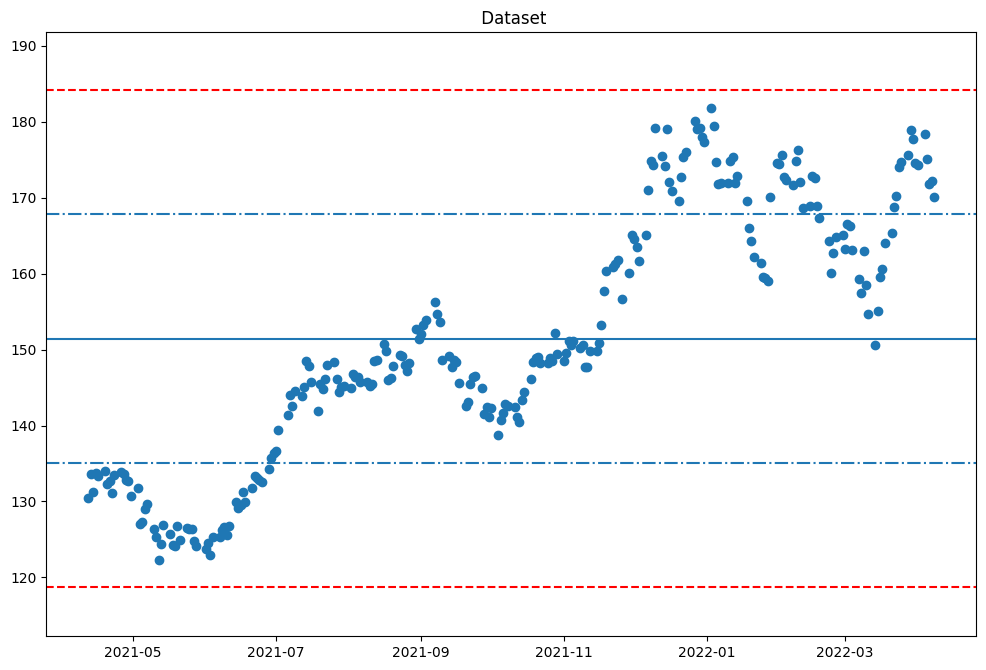

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# a=ticker.history( period='52wk', interval='1d' )[['High','Low']]
a=ticker.history( period='52wk', interval='1d' )[['Close']]

plt.title(" Dataset")
plt.ylim(min(a['Close']) - 10, max(a['Close']) + 10)
plt.scatter(x=a.index, y=a['Close'])
# plt.scatter(x=a.index, y=a['Low'])
plt.axhline(y=a['Close'].mean(), xmin=0, xmax=1,  )
# plt.axhline(y=a['Low'].mean(), xmin=0, xmax=1, color='r'  )

plt.axhline(y=a['Close'].mean()+a['Close'].std(), xmin=0, xmax=1, ls='-.' )
# plt.axhline(y=a['Low'].mean()+a['Low'].std(), xmin=0, xmax=1, color='r', ls='-.'  )
plt.axhline(y=a['Close'].mean()-a['Close'].std(), xmin=0, xmax=1, ls='-.')
# plt.axhline(y=a['Low'].mean()-a['Low'].std(), xmin=0, xmax=1, color='r', ls='-.' )

plt.axhline(y=a['Close'].mean()+2*a['Close'].std(), xmin=0, xmax=1, ls='--', color='r')
# plt.axhline(y=a['Low'].mean()+2*a['Low'].std(), xmin=0, xmax=1, color='r', ls='--' )
plt.axhline(y=a['Close'].mean()-2*a['Close'].std(), xmin=0, xmax=1, ls='--', color='r'  )
# plt.axhline(y=a['Low'].mean()-2*a['Low'].std(), xmin=0, xmax=1, color='r', ls='--'  )

# plt.axhline(y=a['Close'].mean()+3*a['Close'].std(), xmin=0, xmax=1  )
# plt.axhline(y=a['Close'].mean()-3*a['Close'].std(), xmin=0, xmax=1, color='r' )

plt.show()



In [ ]:
 ' '.join([prop for prop in ticker.info ])

'zip sector fullTimeEmployees longBusinessSummary city phone state country companyOfficers website maxAge address1 industry ebitdaMargins profitMargins grossMargins operatingCashflow revenueGrowth operatingMargins ebitda targetLowPrice recommendationKey grossProfits freeCashflow targetMedianPrice currentPrice earningsGrowth currentRatio returnOnAssets numberOfAnalystOpinions targetMeanPrice debtToEquity returnOnEquity targetHighPrice totalCash totalDebt totalRevenue totalCashPerShare financialCurrency revenuePerShare quickRatio recommendationMean exchange shortName longName exchangeTimezoneName exchangeTimezoneShortName isEsgPopulated gmtOffSetMilliseconds quoteType symbol messageBoardId market annualHoldingsTurnover enterpriseToRevenue beta3Year enterpriseToEbitda 52WeekChange morningStarRiskRating forwardEps revenueQuarterlyGrowth sharesOutstanding fundInceptionDate annualReportExpenseRatio totalAssets bookValue sharesShort sharesPercentSharesOut fundFamily lastFiscalYearEnd heldPerc

No handles with labels found to put in legend.


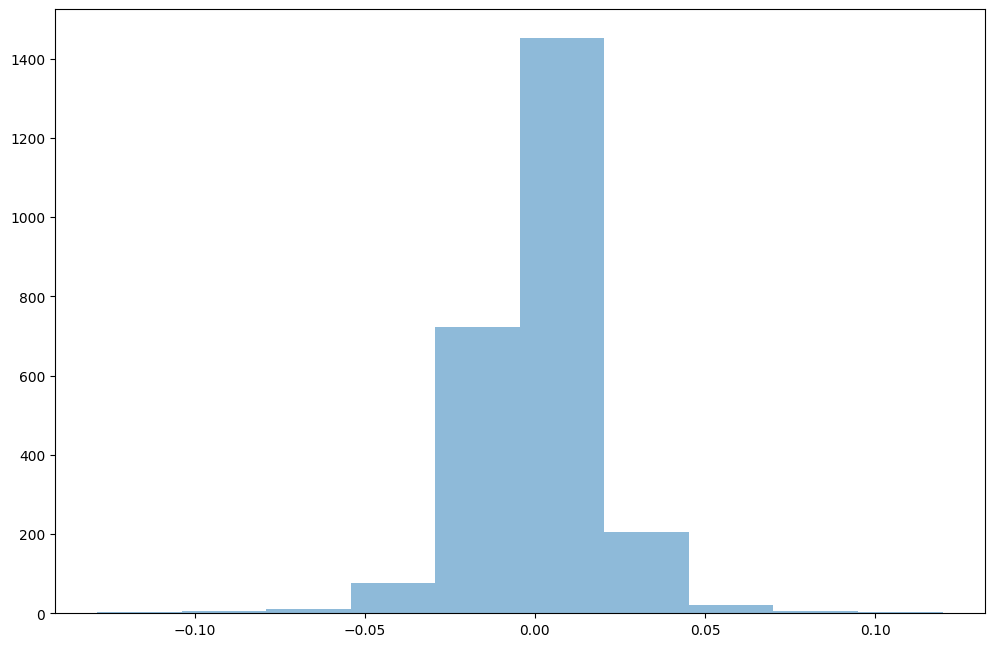

In [137]:
# from scipy.stats import norm
# import numpy as np

# import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
# mean, var, skew, kurt = norm.stats(moments='mvsk')
# ax.plot(x, norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')

# rv = norm()
# ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
# r = norm.rvs(size=1000)
# ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
# a=ticker.history(interval='1d', period='52wk')['Close']
# x = np.linspace( 1, 50, 360)
a=ticker.history( period='520wk', interval='1d' )[['Close']]

# ax.hist((a.diff()).values, density=True, histtype='stepfilled', alpha=0.2)
ax.hist((a.pct_change()).values,  alpha=0.5)

ax.legend(loc='best', frameon=False)
plt.show()


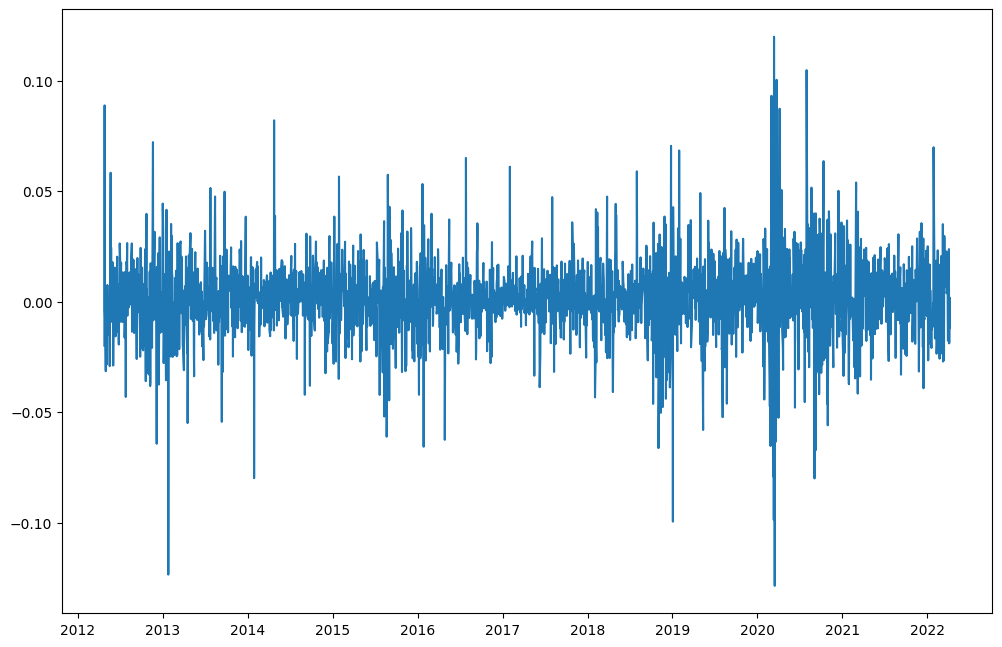

In [143]:
# a.mean()
# plt.plot(a.diff())
plt.plot(a.pct_change())

In [132]:
a=ticker.history( period='52wk', interval='1d' )[['Close']]
a['abs_change'] = a.diff()
a['pct_change'] = a['Close'].pct_change()
a.std()


Close         16.375056
abs_change     2.386097
pct_change     0.015279
dtype: float64

In [105]:
round(a['Close'].pct_change().std()*np.sqrt(365)*100,2)

29.19

In [128]:
b=ticker.history( interval='1d', start='2020-03-01', end='2021-03-01' )[['Close']]
round(b['Close'].pct_change().std()*np.sqrt(365)*100,2)
# len(b['Close']) = 254 !


54.97

In [119]:
ticker.get_info().get('beta')

1.187745